In [309]:
import deepdish as dd
import numpy as np
from brainiak.eventseg import event
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial.distance import jensenshannon
from scipy.stats import zscore, pearsonr
import time
import pandas as pd
from scipy.stats import spearmanr

In [2]:
sent_label_df = pd.read_csv('data/sentence_labels.csv')
sent_label_df_r1 = sent_label_df[sent_label_df['run']=='story1'].reset_index()
sent_label_df_r2 = sent_label_df[sent_label_df['run']=='story2'].reset_index()
sent_label_df_r3 = sent_label_df[sent_label_df['run']=='story3'].reset_index()

In [227]:
paranoia_score = pd.read_csv('data/participants.csv')

p_score = list(paranoia_score['gptsa_score'][:17])

In [276]:
p_score

[22, 16, 18, 20, 18, 18, 19, 38, 17, 23, 24, 40, 17, 20, 17, 21, 16]

In [6]:
i = 0
sent_label_df_r1['sentence_offset_inrun']

T1 = 526
T2 = 452
T3 = 332
nSubj=13
ment_r1 = np.zeros(T1)
ment_r2 = np.zeros(T2)
ment_r3 = np.zeros(T3)

sent_r1 = np.zeros(T1)
sent_r2 = np.zeros(T2)
sent_r3 = np.zeros(T3)


In [7]:
for i in range(1,len(sent_label_df_r1['sentence_offset_inrun'])-1):
    ment_r1[sent_label_df_r1['sentence_offset_inrun'].loc[i]:sent_label_df_r1['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r1['mentalizing_event'].loc[i]
    sent_r1[sent_label_df_r1['sentence_offset_inrun'].loc[i]:sent_label_df_r1['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r1['sentiment'].loc[i]
    
for i in range(1,len(sent_label_df_r2['sentence_offset_inrun'])-1):
    ment_r2[sent_label_df_r2['sentence_offset_inrun'].loc[i]:sent_label_df_r2['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r2['mentalizing_event'].loc[i]
    sent_r2[sent_label_df_r2['sentence_offset_inrun'].loc[i]:sent_label_df_r2['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r1['sentiment'].loc[i]

for i in range(1,len(sent_label_df_r3['sentence_offset_inrun'])-1):
    ment_r3[sent_label_df_r3['sentence_offset_inrun'].loc[i]:sent_label_df_r3['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r3['mentalizing_event'].loc[i]
    sent_r3[sent_label_df_r3['sentence_offset_inrun'].loc[i]:sent_label_df_r3['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r3['sentiment'].loc[i]



In [8]:
sent_label_df_r1['sentence_offset_inrun'].loc[i]

359

In [11]:
sent_label_df_r1['mentalizing_event']

0     0
1     0
2     0
3     1
4     0
     ..
93    1
94    1
95    1
96    0
97    0
Name: mentalizing_event, Length: 98, dtype: int64

In [202]:
PMC_r1 = np.load('data/run1_PMC.npy')
PMC_r2 = np.load('data/run2_PMC.npy')
PMC_r3 = np.load('data/run3_PMC.npy')
for i in range(17):
    PMC_r1_z[:,:,i] = zscore(PMC_r1[:,:,i], axis = 1)
    PMC_r2_z[:,:,i] = zscore(PMC_r2[:,:,i], axis = 1)
    PMC_r3_z[:,:,i] = zscore(PMC_r3[:,:,i], axis = 1)

In [203]:
mPFC_r1 = np.load('data/run1_mPFC.npy')
mPFC_r2 = np.load('data/run2_mPFC.npy')
mPFC_r3 = np.load('data/run3_mPFC.npy')
for i in range(17):
    mPFC_r1_z[:,:,i] = zscore(mPFC_r1[:,:,i], axis = 1)
    mPFC_r2_z[:,:,i] = zscore(mPFC_r2[:,:,i], axis = 1)
    mPFC_r3_z[:,:,i] = zscore(mPFC_r3[:,:,i], axis = 1)

In [204]:
AG_r1 = remove_nonzero_voxels(np.load('data/run1_AG.npy'))
AG_r2 = remove_nonzero_voxels(np.load('data/run2_AG.npy'))
AG_r3 = remove_nonzero_voxels(np.load('data/run3_AG.npy'))
for i in range(17):
    AG_r1_z[:,:,i] = zscore(AG_r1[:,:,i], axis = 1)
    AG_r2_z[:,:,i] = zscore(AG_r2[:,:,i], axis = 1)
    AG_r3_z[:,:,i] = zscore(AG_r3[:,:,i], axis = 1)

In [205]:
TP_r1 = remove_nonzero_voxels(np.load('data/run1_temporal_pole.npy'))
TP_r2 = remove_nonzero_voxels(np.load('data/run2_temporal_pole.npy'))
TP_r3 = remove_nonzero_voxels(np.load('data/run3_temporal_pole.npy'))
for i in range(17):
    TP_r1_z[:,:,i] = zscore(TP_r1[:,:,i], axis = 1)
    TP_r2_z[:,:,i] = zscore(TP_r2[:,:,i], axis = 1)
    TP_r3_z[:,:,i] = zscore(TP_r3[:,:,i], axis = 1)

In [137]:
def remove_nonzero_voxels(data):
    nonzero_voxels = []
    for i in range(data.shape[0]):
        if np.count_nonzero(data[i,:,:] == np.zeros((data[i,:,:].shape)))!=data[0,:,:].shape[0]*data[1,:,:].shape[1]:
            nonzero_voxels.append(i)
    return data[nonzero_voxels,:,:]


In [220]:
TP_r1[0,:,:].shape[0]

(526, 17)

In [145]:
def JS(segments_, T):
    state_dist=np.zeros(T)
    for t in range(T):
        dist_t = []
        for s1 in range(len(segments_)):
            for s2 in range(len(segments_)):
                # For each pair of subjects, measure the
                # divergence between event probabilities
                # at this timepoint 
                dist = jensenshannon(segments_[s1][t,:],
                                     segments_[s2][t,:], base=2)
                dist_t.append(dist)
        avg_dist=np.mean(dist_t)
        state_dist[t] = avg_dist
    return state_dist


In [208]:
def find_js_divergence(fMRI_data, K, T, nSubj=13):
    print('Fitting with all subjects...')
    es_PMC = event.EventSegment(K)
    es_PMC.fit([fMRI_data[:,:,s].T for s in range(nSubj)])

    #print('Fitting with on first half...')
    #es_PMC_g1 = event.EventSegment(K)
    #es_PMC_g1.fit([fMRI_data[:,:,s].T for s in range(nSubj//2)])

#     print('Fitting with on second half...')
#     es_PMC_g2 = event.EventSegment(K)
#     es_PMC_g2.fit([fMRI_data[:,:,s].T for s in range(nSubj//2,nSubj)]);

    # Compute expected value of the event distribtion at each timepoint
    # This indicates how far along the event sequence each subject is
    expval = [es_PMC.segments_[s]@np.arange(K) for s in range(nSubj)]
#     expval_g1 = [es_PMC_g1.segments_[s]@np.arange(K) for s in range(nSubj//2)]
#     expval_g2 = [es_PMC_g2.segments_[s]@np.arange(K) for s in range(nSubj//2)]

    # For each subject, compare where they are in the event sequence vs.
    # the average across all subjects
    lead_lag = np.zeros((nSubj,T))
#     lead_lag_sh = np.zeros((nSubj,T))

    # To get a result in units of seconds: a subject that jumped immediately
    # to the last event would be ahead by (K-1) events, which should
    # correspond to leading by the entire timecourse = T timepoints * 2 sec/TR
    # This gives a conversion factor of (T*2/(K-1))

    for s in range(nSubj):
        lead_lag[s,:] = (expval[s] - np.mean(expval,axis=0))*(T*2/(K-1))
#         try:
#             if s < nSubj//2:
#                 lead_lag_sh[s,:] = (expval_g1[s] - np.mean(expval_g1,axis=0))*(T*2/(K-1))
#             else:
#                 lead_lag_sh[s,:] = (expval_g2[s-nSubj//2] - np.mean(expval_g2,axis=0))*(T*2/(K-1))
#         except:
#             continue

    js = JS(es_PMC.segments_,T)
#     js_g1 = JS(es_PMC_g1.segments_)
#     js_g2 = JS(es_PMC_g2.segments_)

    return js, expval#, js_g1, js_g2

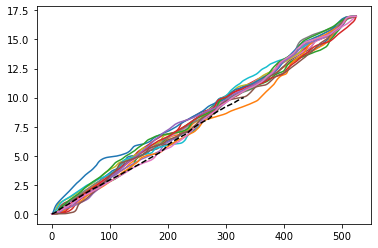

In [254]:
[plt.plot(expval_PMC_r1[i]) for i in range(17)]
plt.plot(np.mean(expval_PMC_r3,axis=0), 'k--', )

In [320]:
js_PMC_r1, expval_PMC_r1 = find_js_divergence(PMC_r1_z, K = 17, T = T1, nSubj=17)
js_PMC_r2, expval_PMC_r2 = find_js_divergence(PMC_r2_z, K = 6, T = T2, nSubj=17)
js_PMC_r3, expval_PMC_r3 = find_js_divergence(PMC_r3_z, K = 16, T = T3, nSubj=17)


Fitting with all subjects...
Fitting with all subjects...
Fitting with all subjects...


In [321]:
js_mPFC_r1, expval_mPFC_r1 = find_js_divergence(mPFC_r1_z, K = 15, T = T1, nSubj=17)
js_mPFC_r2, expval_mPFC_r2 = find_js_divergence(mPFC_r2_z, K = 15,T = T2, nSubj=17)
js_mPFC_r3, expval_mPFC_r3 = find_js_divergence(mPFC_r3_z, K = 5, T = T3, nSubj=17)


Fitting with all subjects...
Fitting with all subjects...
Fitting with all subjects...


In [322]:
js_AG_r1, expval_AG_r1 = find_js_divergence(AG_r1_z, K = 25, T = T1, nSubj=17)
js_AG_r2, expval_AG_r2 = find_js_divergence(AG_r2_z, K = 25,T = T2, nSubj=17)
js_AG_r3, expval_AG_r3 = find_js_divergence(AG_r3_z, K = 15, T = T3, nSubj=17)


Fitting with all subjects...
Fitting with all subjects...
Fitting with all subjects...


In [323]:
js_TP_r1, expval_TP_r1 = find_js_divergence(TP_r1_z, K = 8, T = T1, nSubj=17)
js_TP_r2, expval_TP_r2 = find_js_divergence(TP_r2_z, K = 8,T = T2, nSubj=17)
js_TP_r3, expval_TP_r3 = find_js_divergence(TP_r3_z, K = 5, T = T3, nSubj=17)


Fitting with all subjects...
Fitting with all subjects...
Fitting with all subjects...


### Plot a grid of event expectation over time for each run and subject

In [324]:
all_expval = [expval_PMC_r1, expval_PMC_r2, expval_PMC_r3, expval_mPFC_r1, expval_mPFC_r2, expval_mPFC_r3, expval_AG_r1, expval_AG_r2, expval_AG_r3, expval_TP_r1, expval_TP_r2, expval_TP_r3]

all_expval_labels = ['PMC', 'mPFC', 'AG', 'TP']
all_expval_runs = ['Run 1', 'Run 2', 'Run 3']

all_expval_diff = [x - np.mean(x, axis = 0) for x in all_expval]

In [335]:
stored_results = []

# iterate through regions, all_expval_diff has the shape of regions x subjects x TRs
# average over TRs for average divergence per subject and correlate with p_score, p_score should already be in the same 
# order as the subject data
for x in all_expval_diff:
    averaged_over_time = np.mean(x, axis = 1)
    assert averaged_over_time.shape == (17, )
    rho, p = pearsonr(averaged_over_time, p_score)
    stored_results.append([rho, p])
    
    

In [336]:
for s in range(len(stored_results)):
    print(all_expval_labels[s // 3] + all_expval_runs[s % 3], sep = ' ')
    print(stored_results[s])

PMCRun 1
[-0.31822590868947775, 0.21320067996817402]
PMCRun 2
[0.1891623096757079, 0.4671441077526207]
PMCRun 3
[0.002252008146071833, 0.9931558744446627]
mPFCRun 1
[0.3487766589904684, 0.1700467363391695]
mPFCRun 2
[-0.4117428754963539, 0.10056001213028197]
mPFCRun 3
[-0.3300690945398964, 0.19570801610058441]
AGRun 1
[-0.6869603113397702, 0.002316000354759649]
AGRun 2
[0.3144877292043032, 0.21892513289522697]
AGRun 3
[0.11789664891455426, 0.652240729690895]
TPRun 1
[-0.14076512659297913, 0.5899717746056508]
TPRun 2
[0.2090001484843736, 0.42079562705205475]
TPRun 3
[-0.1331687261555121, 0.6103839348385829]


Text(0, 0.5, 'Expected value of HMM event')

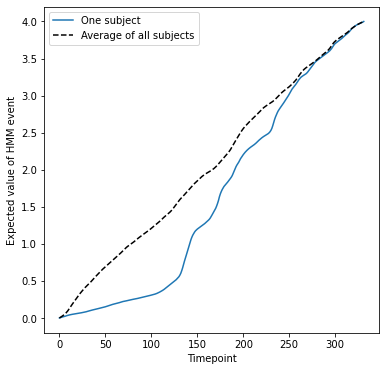

In [360]:
# As an example, we can plot one subject's expected value
# vs. the group average
_, ax = plt.subplots(figsize=(6,6))
ax.plot(expval_TP_r3[10])
ax.plot(np.mean(expval_TP_r3,axis=0), 'k--')
ax.legend(['One subject','Average of all subjects'])

ax.set_xticks(np.arange(0,T3,50))
#ax.set_xticklabels([time.strftime('%M:%S', time.gmtime((b)*2)) for b in np.arange(0,T1,50)])
ax.set_xlabel('Timepoint')
ax.set_ylabel('Expected value of HMM event')

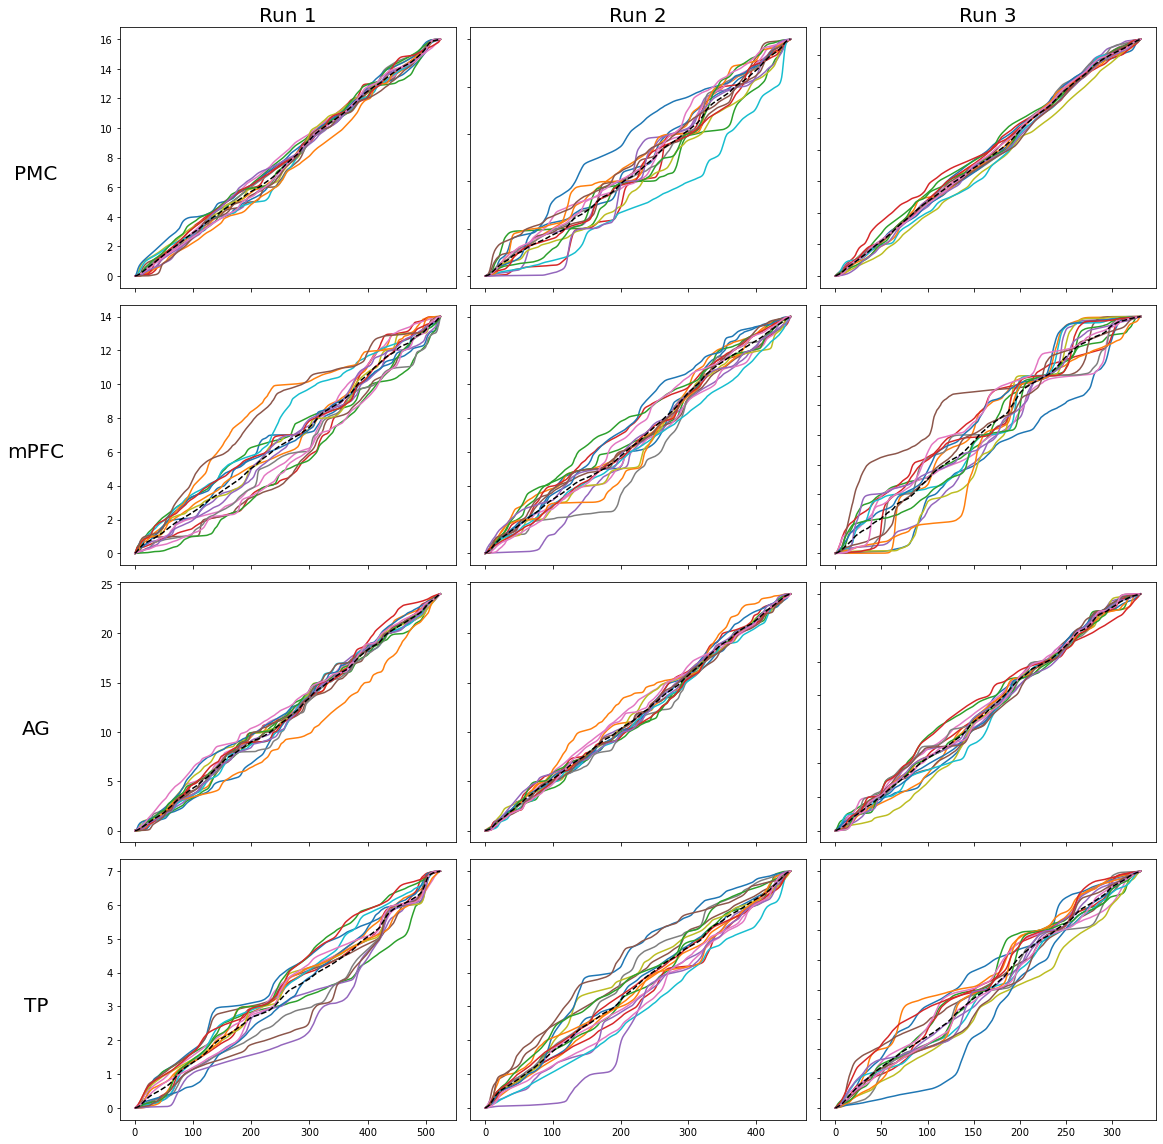

In [350]:
fig, axs = plt.subplots(4, 3, figsize=(16, 16))
counter = 0
for it in range(4):
    for it2 in range(3):
        current_ax = axs[it, it2]
        current_data = all_expval[counter]
        
        [current_ax.plot(current_data[i]) for i in range(len(current_data))]
        current_ax.plot(np.mean(current_data,axis=0), 'k--', )
        
        counter += 1
        


for ax, row in zip(axs[:, 0], all_expval_labels):
    ax.set_ylabel(row, size = 20, rotation = 0)
    ax.yaxis.set_label_coords(-0.25, .4)

for ax, col in zip(axs[0], all_expval_runs):
    ax.set_title(col, size = 20)
    
for ax in axs.flat:
    ax.label_outer()
    
plt.tight_layout()








In [328]:
def plot_js_ment(ment, js_run, T, trim = 25):
    HRF_shift = 5

    #interest_trim = emo[emotion_names == 'Interest',trim:-trim].squeeze()
    ment_trim = ment[trim:-trim]
    JS_trim = js_run[(trim+HRF_shift):(-trim+HRF_shift)]
    #JS_g1_trim = js_g1[(trim+HRF_shift):(-trim+HRF_shift)]
    #JS_g2_trim = js_g2[(trim+HRF_shift):(-trim+HRF_shift)]
    
    fig, ax1 = plt.subplots(figsize=(8,5))
    ax1.plot(np.arange(trim, T-trim), ment_trim)
    ax1.set_ylabel('Sentiment', color='C0')
    ax1.tick_params(axis='y', color='C0', labelcolor='C0')
    ax1.set_xlabel('Timepoint')
    ax1.set_xticks(np.arange(0, T,50))
    #ax1.set_xlim(-18.8, 394.8)
    ax2 = ax1.twinx()
    ax2.plot(np.arange(trim, T-trim), JS_trim, color='k')
    ax2.set_ylabel('JS Divergence')
    print(str(spearmanr(ment_trim,JS_trim)))

SpearmanrResult(correlation=0.0041137195482079955, pvalue=0.9286724996862474)
SpearmanrResult(correlation=0.0654004648775591, pvalue=0.19067212606008957)
SpearmanrResult(correlation=0.010652278908247367, pvalue=0.8586501785942199)


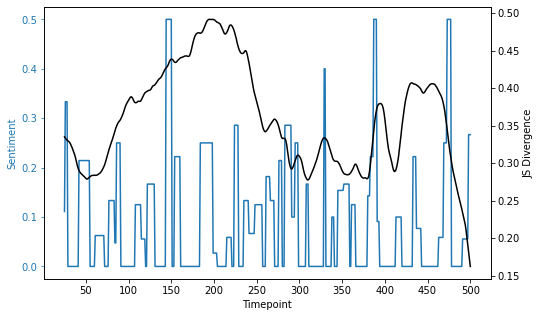

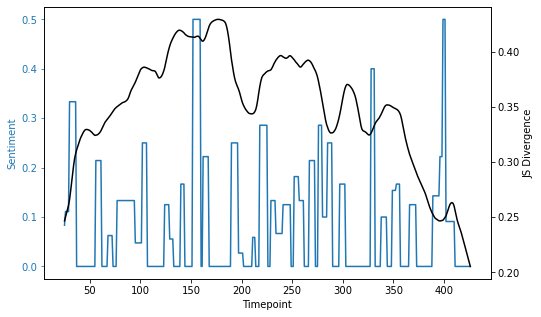

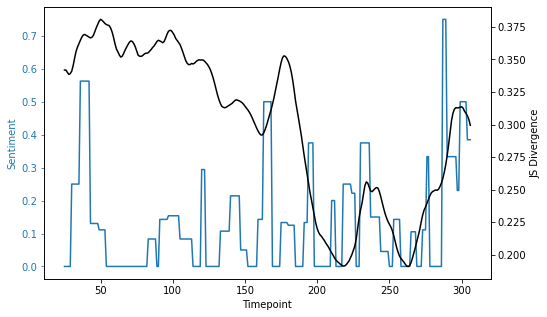

In [329]:
plot_js_ment(abs(sent_r1),js_PMC_r1,T = T1)
plot_js_ment(abs(sent_r2),js_PMC_r2,T = T2)
plot_js_ment(abs(sent_r3),js_PMC_r3,T = T3)


SpearmanrResult(correlation=0.0957501277712418, pvalue=0.03676818134191066)
SpearmanrResult(correlation=0.07155289176613476, pvalue=0.15214389978480608)
SpearmanrResult(correlation=-0.23154180287006912, pvalue=8.693194354560972e-05)


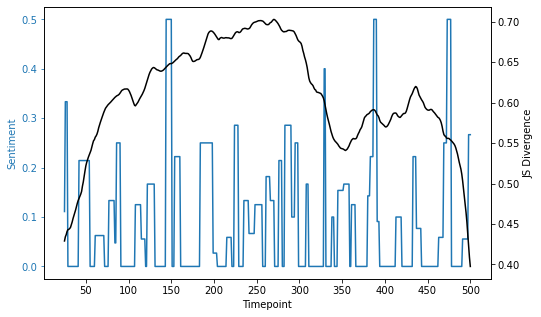

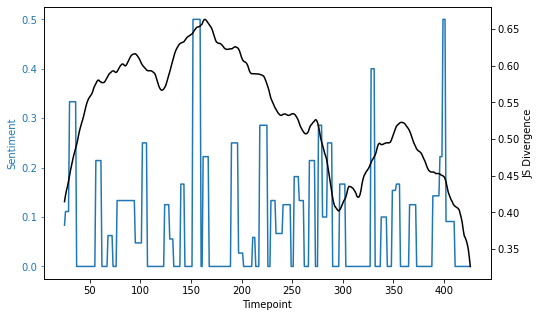

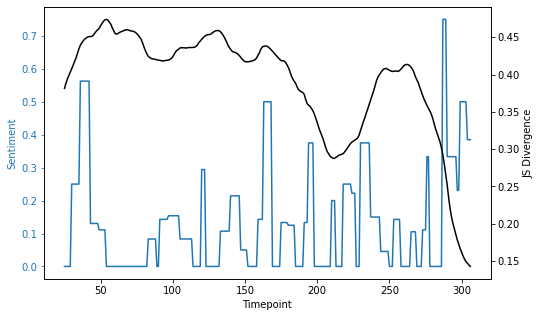

In [330]:
plot_js_ment(np.abs(sent_r1),js_mPFC_r1,T = T1)
plot_js_ment(np.abs(sent_r2),js_mPFC_r2,T = T2)
plot_js_ment(np.abs(sent_r3),js_mPFC_r3,T = T3)

SpearmanrResult(correlation=0.01140957721197413, pvalue=0.8039168590136345)
SpearmanrResult(correlation=0.04751912054778392, pvalue=0.3419468610985712)
SpearmanrResult(correlation=-0.30762021155139124, pvalue=1.3549943549306413e-07)


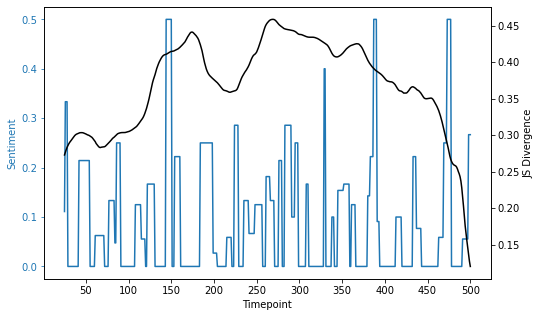

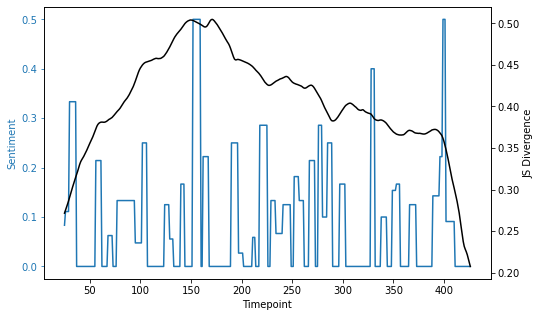

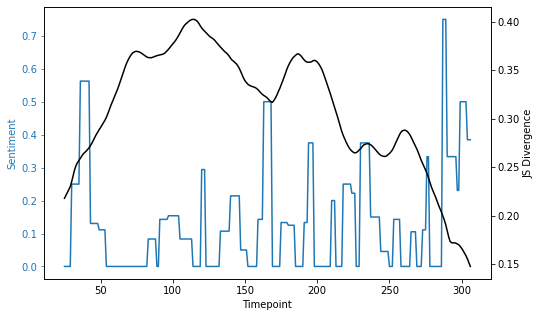

In [331]:
plot_js_ment(np.abs(sent_r1),js_TP_r1,T = T1)
plot_js_ment(np.abs(sent_r2),js_TP_r2,T = T2)
plot_js_ment(np.abs(sent_r3),js_TP_r3,T = T3)

SpearmanrResult(correlation=-0.005059102626041764, pvalue=0.9123403087046451)
SpearmanrResult(correlation=0.09935113066815347, pvalue=0.04651291570563417)
SpearmanrResult(correlation=-0.14896102290779875, pvalue=0.012267389368878119)


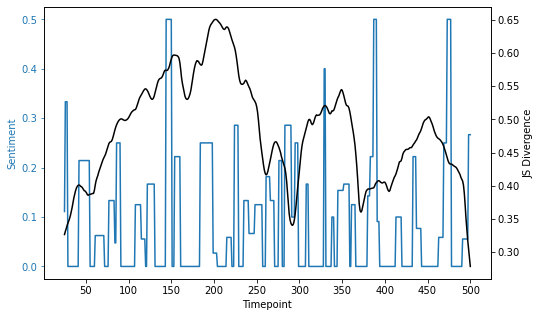

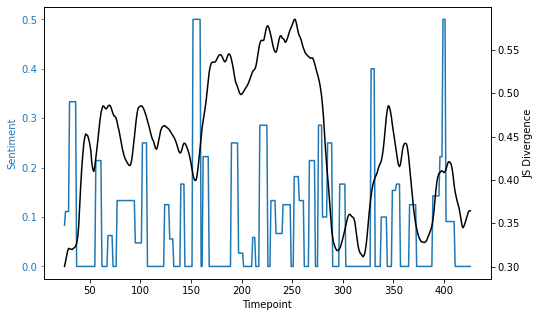

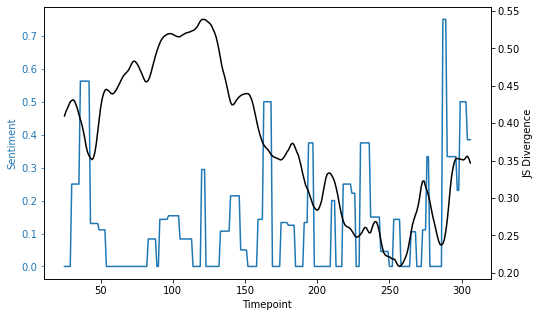

In [332]:
plot_js_ment(np.abs(sent_r1),js_AG_r1,T = T1)
plot_js_ment(np.abs(sent_r2),js_AG_r2,T = T2)
plot_js_ment(np.abs(sent_r3),js_AG_r3,T = T3)

In [ ]:
# Plot correlation matrix for (z-scored) emotions
plt.imshow(np.corrcoef(r1_group.T))

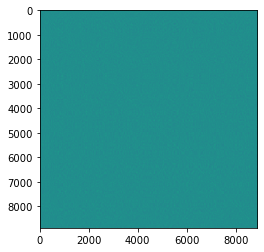

In [211]:
plt.imshow(np.corrcoef(r2_group.T))

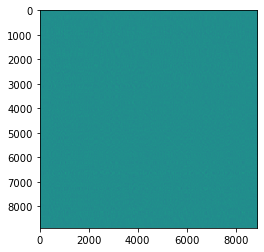

In [212]:
plt.imshow(np.corrcoef(r3_group.T))